# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = '1124-Scene3-CLSTMC-win120'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 120

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + 18, tx + 18
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(11071, 10671)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([120, 3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape, y.shape

(torch.Size([120, 6]), torch.Size([120, 3]))

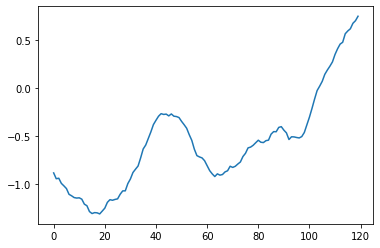

In [11]:
plt.plot(x[:, 2])

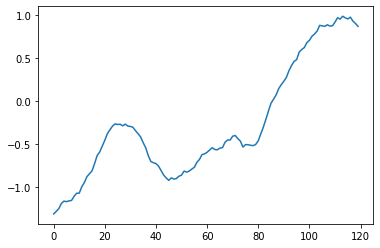

In [12]:
plt.plot(y[:, 2])

# 모델 생성

In [13]:
class ResBlock1d(nn.Module):
    def __init__(self, inchannels, channels, kernel_size):
        super(ResBlock1d, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(inchannels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(channels)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(inchannels, channels, 1),
            nn.BatchNorm1d(channels)
        )
        self.act = nn.LeakyReLU()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        identity = self.conv2(identity)
        x += identity
        x = self.act(x)

        return x

In [14]:
class CLSTMC(nn.Module):
    def __init__(self):
        super(CLSTMC, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(6, 24, 3, padding=1, groups=2),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(),
            nn.Conv1d(24, 48, 3, padding=1, groups=2),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(),
            nn.Conv1d(48, 64, 3, padding=1),
            nn.BatchNorm1d(64),
        )

        self.rnn = nn.LSTM(input_size=64,
                           hidden_size=64,
                           num_layers=6,
                           batch_first=True,
                           dropout=0,
                           bidirectional=True)

        self.conv_out = nn.Sequential(
            ResBlock1d(128, 64, 3),
            nn.Conv1d(64, 3, 1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # B, S, 6 --> B, 6, S
        x = self.conv_in(x)  # B, 6, S
        x = x.transpose(1, 2)  # B, S, 6

        outs, (hiddens, cells) = self.rnn(x)  # B, S, 128
        x = outs.transpose(1, 2)  # B, 128, S
        x = self.conv_out(x) # (B, 3, S)
        x = x.transpose(1, 2)

        return x

In [15]:
model = CLSTMC().cuda()

In [16]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [17]:
class HPMetric(tb.metrics.InvisibleMetric):
    def __init__(self, name: str):
        super(HPMetric, self).__init__(name)

        self.diff = []

    def on_valid_epoch_end(self, epoch: int, logs: dict):
        # RMS, 99% tile 출력
        yaw_v, pitch_v, roll_v, rms_v, tile99_v = self._calc_values(self.diff)

        print(f'                  validation')
        print(f' - Yaw          : {yaw_v:10f}')
        print(f' - Pitch        : {pitch_v:10f}')
        print(f' - Roll         : {roll_v:10f}')
        print(f' - RMS          : {rms_v:10f}')
        print(f' - 99% Tile     : {tile99_v:10f}')

        self.diff.clear()

    def get_value(self, outputs: torch.Tensor, targets: torch.Tensor, is_train: bool):
        if not is_train:
            self.diff.append((outputs - targets).mean(1).detach().cpu())  # (B, S, 3) --> (B, 3)

    @staticmethod
    def _calc_values(diff):
        diff = torch.cat(diff).abs_()  # (D, 3)
        rms = (diff.square().sum(1) / 3).sqrt()
        tile = rms.flatten().numpy()
        tile99 = np.percentile(tile, 99)
        
        mrms = rms.mean()
        
        # diff = radian2degree(diff)
        #tile = diff.flatten().numpy()
        #tile99 = np.percentile(tile, 99)

        mdiff = diff.mean(dim=0)
        #rms = (mdiff.square().sum() / 3).sqrt()

        return mdiff[0].item(), mdiff[1].item(), mdiff[2].item(), mrms.item(), tile99

In [18]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           HPMetric('hp_metric')]

In [19]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0], patience=3),
             tb.callbacks.SaveCheckpoint({'model': model}, metrics[0], CHECKPOINT_DIR, 'best-ckpt.pth')]

In [20]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [21]:
trainer.fit(ds_train, ds_test, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0002/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from inf to 228.50000853765587
                  validation
 - Yaw          :  17.926659
 - Pitch        :  10.015243
 - Roll         :   2.376736
 - RMS          :  12.846241
 - 99% Tile     :  26.489463


[0003/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 228.50000853765587 to 165.70958709716797
                  validation
 - Yaw          :  15.332274
 - Pitch        :   8.665665
 - Roll         :   2.151417
 - RMS          :  11.067415
 - 99% Tile     :  21.810583


[0004/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 165.70958709716797 to 147.17557670956566
                  validation
 - Yaw          :  14.518229
 - Pitch        :   8.065058
 - Roll         :   2.055353
 - RMS          :  10.464715
 - 99% Tile     :  20.218567


[0005/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 147.17557670956566 to 131.27382133120585
                  validation
 - Yaw          :  13.688408
 - Pitch        :   7.653961
 - Roll         :   2.076565
 - RMS          :   9.936545
 - 99% Tile     :  18.782461


[0006/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 131.27382133120585 to 115.6361320132301
                  validation
 - Yaw          :  12.769813
 - Pitch        :   7.237369
 - Roll         :   2.051905
 - RMS          :   9.343727
 - 99% Tile     :  17.546098


[0007/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 115.6361320132301 to 96.76786159333729
                  validation
 - Yaw          :  11.450620
 - Pitch        :   6.640149
 - Roll         :   2.016035
 - RMS          :   8.495048
 - 99% Tile     :  16.193470


[0008/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 96.76786159333729 to 79.50802385239373
                  validation
 - Yaw          :  10.195645
 - Pitch        :   6.048751
 - Roll         :   1.945686
 - RMS          :   7.696148
 - 99% Tile     :  14.847071


[0009/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 79.50802385239373 to 58.89763745807466
                  validation
 - Yaw          :   8.218656
 - Pitch        :   5.241995
 - Roll         :   1.855505
 - RMS          :   6.477643
 - 99% Tile     :  13.817162


[0010/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 58.89763745807466 to 53.51375952221098
                  validation
 - Yaw          :   8.040444
 - Pitch        :   5.037437
 - Roll         :   1.804152
 - RMS          :   6.254033
 - 99% Tile     :  12.471625


[0011/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 53.51375952221098 to 40.44303049360003
                  validation
 - Yaw          :   6.651686
 - Pitch        :   4.276628
 - Roll         :   1.669069
 - RMS          :   5.296397
 - 99% Tile     :  12.346788


[0012/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 40.44303049360003 to 34.98085878008888
                  validation
 - Yaw          :   6.293433
 - Pitch        :   3.949524
 - Roll         :   1.575865
 - RMS          :   4.990197
 - 99% Tile     :  10.149118


[0013/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 34.98085878008888 to 22.597656749543688
                  validation
 - Yaw          :   4.712159
 - Pitch        :   3.331289
 - Roll         :   1.410649
 - RMS          :   3.953480
 - 99% Tile     :   8.060875


[0014/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 22.597656749543688 to 19.39797634170169
                  validation
 - Yaw          :   4.646523
 - Pitch        :   2.502844
 - Roll         :   1.226772
 - RMS          :   3.551693
 - 99% Tile     :   7.809435


[0015/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 19.39797634170169 to 9.179538573537554
                  validation
 - Yaw          :   2.577679
 - Pitch        :   2.095920
 - Roll         :   1.054314
 - RMS          :   2.308965
 - 99% Tile     :   5.847565


[0016/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.235785
 - Pitch        :   1.763732
 - Roll         :   0.875558
 - RMS          :   2.481508
 - 99% Tile     :   5.240201


[0017/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 9.179538573537554 to 5.168369974408832
                  validation
 - Yaw          :   1.410815
 - Pitch        :   1.892520
 - Roll         :   0.750961
 - RMS          :   1.656278
 - 99% Tile     :   3.877732


[0018/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.168369974408832 to 5.156272760459355
                  validation
 - Yaw          :   2.215605
 - Pitch        :   1.153928
 - Roll         :   0.851700
 - RMS          :   1.692829
 - 99% Tile     :   3.962271


[0019/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.989848
 - Pitch        :   1.417715
 - Roll         :   0.495719
 - RMS          :   1.606084
 - 99% Tile     :   4.568130


[0020/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.156272760459355 to 3.2562222381432844
                  validation
 - Yaw          :   1.282272
 - Pitch        :   1.152230
 - Roll         :   0.511208
 - RMS          :   1.146400
 - 99% Tile     :   3.162878


[0021/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.458392
 - Pitch        :   1.588181
 - Roll         :   0.507434
 - RMS          :   1.494626
 - 99% Tile     :   3.037603


[0022/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 3.2562222381432844 to 1.9231813223589034
                  validation
 - Yaw          :   0.683663
 - Pitch        :   0.785767
 - Roll         :   0.492613
 - RMS          :   0.769289
 - 99% Tile     :   2.298720


[0023/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.159485
 - Pitch        :   0.760073
 - Roll         :   0.417117
 - RMS          :   0.924606
 - 99% Tile     :   2.858362


[0024/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.087560
 - Pitch        :   0.679195
 - Roll         :   0.413270
 - RMS          :   0.866605
 - 99% Tile     :   2.345267


[0025/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.9231813223589034 to 1.6045057745206923
                  validation
 - Yaw          :   0.788512
 - Pitch        :   0.713866
 - Roll         :   0.407967
 - RMS          :   0.756923
 - 99% Tile     :   2.071214


[0026/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.269700
 - Pitch        :   0.592879
 - Roll         :   0.509328
 - RMS          :   0.981389
 - 99% Tile     :   2.902839


[0027/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.082778
 - Pitch        :   0.795566
 - Roll         :   0.418938
 - RMS          :   0.907642
 - 99% Tile     :   3.584212


[0028/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.6045057745206923 to 1.5195971365485872
                  validation
 - Yaw          :   0.802987
 - Pitch        :   0.580557
 - Roll         :   0.351869
 - RMS          :   0.681322
 - 99% Tile     :   2.350507


[0029/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.179076
 - Pitch        :   0.876344
 - Roll         :   0.402185
 - RMS          :   0.963087
 - 99% Tile     :   2.853034


[0030/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.269126
 - Pitch        :   0.667883
 - Roll         :   0.391191
 - RMS          :   0.955223
 - 99% Tile     :   2.831238


[0031/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.319788
 - Pitch        :   0.916103
 - Roll         :   0.367330
 - RMS          :   1.054325
 - 99% Tile     :   2.471101


[0032/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.5195971365485872 to 1.1558235951122784
                  validation
 - Yaw          :   0.633439
 - Pitch        :   0.417680
 - Roll         :   0.301862
 - RMS          :   0.535034
 - 99% Tile     :   1.653279


[0033/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.893362
 - Pitch        :   0.445666
 - Roll         :   0.271299
 - RMS          :   0.654603
 - 99% Tile     :   2.253777


[0034/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.119446
 - Pitch        :   0.777346
 - Roll         :   0.320830
 - RMS          :   0.888512
 - 99% Tile     :   2.254668


[0035/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.853275
 - Pitch        :   0.597241
 - Roll         :   0.555286
 - RMS          :   0.777471
 - 99% Tile     :   2.416039


[0036/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.897072
 - Pitch        :   0.405920
 - Roll         :   0.263066
 - RMS          :   0.656040
 - 99% Tile     :   2.042233


[0037/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.1558235951122784 to 1.0824682450010663
                  validation
 - Yaw          :   0.526768
 - Pitch        :   0.484435
 - Roll         :   0.225351
 - RMS          :   0.500963
 - 99% Tile     :   1.980285


[0038/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 1.0824682450010663 to 0.9989880671103796
                  validation
 - Yaw          :   0.491904
 - Pitch        :   0.355967
 - Roll         :   0.249785
 - RMS          :   0.435039
 - 99% Tile     :   1.872866


[0039/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.648245
 - Pitch        :   0.515741
 - Roll         :   0.261218
 - RMS          :   0.563689
 - 99% Tile     :   1.998016


[0040/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.644057
 - Pitch        :   0.405726
 - Roll         :   0.254255
 - RMS          :   0.519449
 - 99% Tile     :   1.886139


[0041/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.581714
 - Pitch        :   0.336519
 - Roll         :   0.261625
 - RMS          :   0.472563
 - 99% Tile     :   1.866560


[0042/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.586566
 - Pitch        :   0.385942
 - Roll         :   0.303238
 - RMS          :   0.501424
 - 99% Tile     :   1.856646


[0043/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 0.9989880671103796 to 0.9424480834887141
                  validation
 - Yaw          :   0.408734
 - Pitch        :   0.363473
 - Roll         :   0.240126
 - RMS          :   0.394272
 - 99% Tile     :   1.847652


[0044/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.528065
 - Pitch        :   0.381996
 - Roll         :   0.231605
 - RMS          :   0.447172
 - 99% Tile     :   2.275158


[0045/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.619943
 - Pitch        :   0.311278
 - Roll         :   0.244939
 - RMS          :   0.475762
 - 99% Tile     :   1.894619


[0046/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.588294
 - Pitch        :   0.350045
 - Roll         :   0.233728
 - RMS          :   0.463463
 - 99% Tile     :   1.846131


[0047/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 0.9424480834887141 to 0.9124579427852517
                  validation
 - Yaw          :   0.409713
 - Pitch        :   0.298918
 - Roll         :   0.218268
 - RMS          :   0.365451
 - 99% Tile     :   1.820410


[0048/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.462087
 - Pitch        :   0.372138
 - Roll         :   0.218556
 - RMS          :   0.418206
 - 99% Tile     :   1.904380


[0049/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.375008
 - Pitch        :   0.478638
 - Roll         :   0.255325
 - RMS          :   0.434995
 - 99% Tile     :   1.910246


[0050/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.419183
 - Pitch        :   0.349750
 - Roll         :   0.234481
 - RMS          :   0.389083
 - 99% Tile     :   1.766896


[0051/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.381718
 - Pitch        :   0.324668
 - Roll         :   0.216734
 - RMS          :   0.363410
 - 99% Tile     :   1.894432


[0052/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 0.9124579427852517 to 0.890315696064915
                  validation
 - Yaw          :   0.361841
 - Pitch        :   0.325357
 - Roll         :   0.210836
 - RMS          :   0.354708
 - 99% Tile     :   1.809432


[0053/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.477168
 - Pitch        :   0.333096
 - Roll         :   0.233734
 - RMS          :   0.412482
 - 99% Tile     :   1.868643


[0054/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.424165
 - Pitch        :   0.324730
 - Roll         :   0.216102
 - RMS          :   0.381505
 - 99% Tile     :   1.795229


[0055/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 3.125e-05 to 1.5625e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.410173
 - Pitch        :   0.367931
 - Roll         :   0.214343
 - RMS          :   0.390287
 - 99% Tile     :   1.995506


[0056/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.372319
 - Pitch        :   0.343404
 - Roll         :   0.223580
 - RMS          :   0.364564
 - 99% Tile     :   1.911746


[0057/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.644829
 - Pitch        :   0.326646
 - Roll         :   0.211414
 - RMS          :   0.482854
 - 99% Tile     :   1.754676


[0058/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 1.5625e-05 to 7.8125e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.522374
 - Pitch        :   0.340767
 - Roll         :   0.219362
 - RMS          :   0.435210
 - 99% Tile     :   1.866070


[0059/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 0.890315696064915 to 0.8811310980291593
                  validation
 - Yaw          :   0.353132
 - Pitch        :   0.305832
 - Roll         :   0.210687
 - RMS          :   0.341684
 - 99% Tile     :   1.764493


[0060/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.654197
 - Pitch        :   0.351766
 - Roll         :   0.220700
 - RMS          :   0.504209
 - 99% Tile     :   1.864731


[0061/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.460718
 - Pitch        :   0.300038
 - Roll         :   0.227096
 - RMS          :   0.392892
 - 99% Tile     :   1.842175


[0062/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 7.8125e-06 to 3.90625e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.444976
 - Pitch        :   0.421941
 - Roll         :   0.207121
 - RMS          :   0.421653
 - 99% Tile     :   1.799707


[0063/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.374442
 - Pitch        :   0.332395
 - Roll         :   0.209256
 - RMS          :   0.361630
 - 99% Tile     :   1.748730


[0064/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.894689
 - Pitch        :   0.299852
 - Roll         :   0.218000
 - RMS          :   0.599617
 - 99% Tile     :   1.982252


[0065/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 3.90625e-06 to 1.953125e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.452123
 - Pitch        :   0.311935
 - Roll         :   0.210509
 - RMS          :   0.388141
 - 99% Tile     :   1.858817


[0066/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.492135
 - Pitch        :   0.336444
 - Roll         :   0.210868
 - RMS          :   0.412902
 - 99% Tile     :   1.915483


[0067/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.388888
 - Pitch        :   0.312139
 - Roll         :   0.207170
 - RMS          :   0.357006
 - 99% Tile     :   1.801002


[0068/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 1.953125e-06 to 9.765625e-07 because val_loss did not improved for 3 epochs
val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.445928
 - Pitch        :   0.347313
 - Roll         :   0.218277
 - RMS          :   0.399422
 - 99% Tile     :   1.813715


[0068/0200] Validation: 100%|██████████████████████| 42/42 [00:01<00:00, 22.54it/s, val_loss 0.9781]

val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.529909
 - Pitch        :   0.393005
 - Roll         :   0.211840
 - RMS          :   0.454954
 - 99% Tile     :   1.864552
